# Trabajo final de Percepción remota

## Estimación del Índice de Vegetación de Diferencia Normalizada (NDVI)

### 11 de diciembre de 2018

### Olmo Guerrero Medina

In [1]:
# Required libraries
%matplotlib inline
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap # Import the Basemap toolkit
import numpy as np # Import the Numpy package
from matplotlib.colors import LinearSegmentedColormap # Linear interpolation for color maps
from datetime import datetime
from pyproj import Proj
from cpt_convert import loadCPT # Import the CPT convert function
# Converts the CPT file to be used in Python
cpt = loadCPT('/home/olmo/Documents/Hflux_PR/IR4AVHRR6.cpt')
# Makes a linear interpolation with the CPT file
cpt_convert = LinearSegmentedColormap('cpt', cpt)
from IPython.display import Image
import pandas as pd

In [2]:
#reflectance(radiancia, numero de banda): convierte la radiancia a reflectancia las bandas 1-6 de GOES 16
def reflectance(radiance, band):
    Esun_dict = {1:441.868715,2:663.274497,3:726.721072,4:679.143879,5:634.454241,6:381.148813}
    Esun = Esun_dict[band]
    d2 = 0.3
    refl = (radiance * np.pi * d2) / Esun
    refl = np.maximum(refl, 0.0)
    refl = np.minimum(refl, 1.0)
    return refl

# Rebin function from https://stackoverflow.com/questions/8090229/resize-with-averaging-or-rebin-a-numpy-2d-array
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

# Índice de Vegetación de Diferencia Normalizada (NDVI)

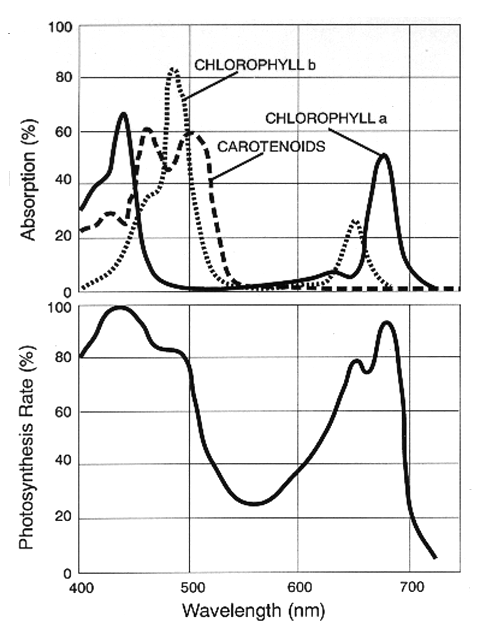

In [5]:
Image(filename='/home/olmo/Documents/Hflux_PR/Par_action_spectrum.png')

Las plantas utilizan para hacer la fotosíntesis una región del espectro electromagnético conocida como Radiación Fotosintéticamente Activa (PAR, por sus siglas en inglés). PAR se encuentra entre los 0.4 $\mu m$ y los 0.7$\mu m$ y corresponde al color rojo en la región visible. Longitudes de onda más grandes no tienen la suficiente energía para sintetizar moléculas orgánicas y su absorción solo resultaría en calentamiento de la planta, por tanto son relfejadas. Entonces las plantas aparecen oscuras en PAR y brillantes en el infrarrojo cercano. Aunque en la imagen se observa que la clorofila tiene dos picos, solo la energía del pico de clorofila-a es relevante en la fotosíntesis (Nobel PS, 1991)

El Índice de Vegetación de Diferencia Normalizada (NDVI, por sus siglas en inglés) es una medida de la cantidad de vegetación que medido en distintas épocas del año puede utilizarse para estudiar su evolución. Se calcula a partir de: 

# $NDVI = \frac{R_{NIR} - R_{red}}{R_{NIR} + R_{red}}$ , 

donde $R_{NIR}$ es la reflectancia de la banda en el infrarojo cercano y $R_{red}$ es la reflectancia de la longitud de onda en el visible rojo. En el caso de los datos de GOES16, estas bandas corresponden a las bandas 2 (rojo) y 3 (Veggie), centradas en 0.64$\mu m$ y 0.865$\mu m$, respectivamente. Con resolución espacial de 1km. Los valores negativos del NDVI se relacionan con nubes, cuerpos de agua y nieve, el valor 0 es el suelo desnudo y las áreas con vegetación tienen valores de entre 0.3 y 0.7, por tanto usualmente se límita su valor al rango 0,1. 

# NDVI nacional (Marzo y Agosto)

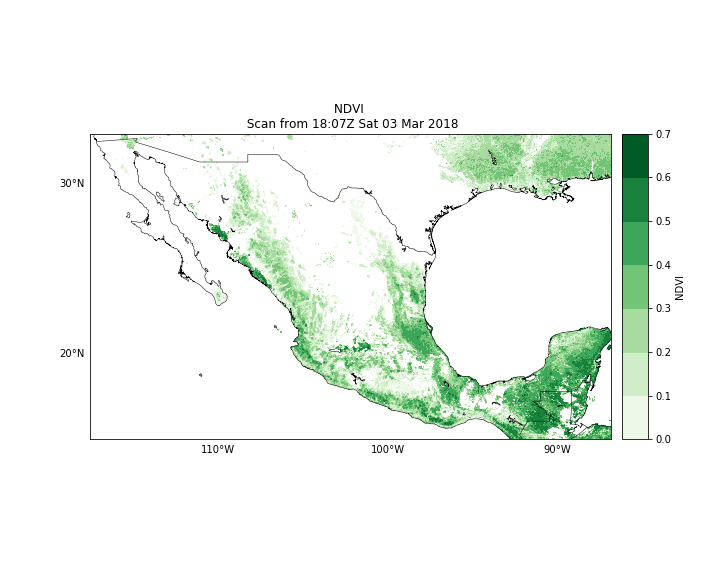

In [174]:
Image(filename='/home/olmo/Documents/Hflux_PR/images/18:07Z Sat 03 Mar 2018.png')

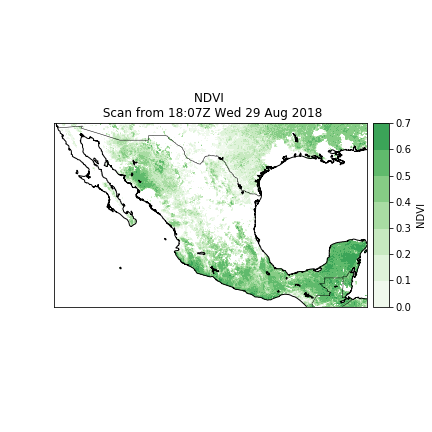

In [175]:
Image(filename='/home/olmo/Documents/Hflux_PR/images/18:07Z Wed 29 Aug 2018.png')

# Estimación del NDVI para el cafetal la Orduña, ubicado a 2 km de Coatepec, Veracruz

In [173]:

path2 ='/home/olmo/Documents/Hflux_PR/data/OR_ABI-L1b-RadC-M3C02_G16_s20182411807196_e20182411809569_c20182411810008.nc'

nc2 = Dataset(path2)
radiance2 = nc2.variables['Rad'][:]
#resample chanel 2:
radiance2= rebin(radiance2, [3000, 5000])
nc2.close()
R = reflectance(radiance2, band = 2)
#gamma = 2.2
#R = np.power(R, 1/gamma)

path3 ='/home/olmo/Documents/Hflux_PR/data/OR_ABI-L1b-RadC-M3C03_G16_s20182411807196_e20182411809569_c20182411810012.nc'

nc3 = Dataset(path3)
ori_proj = nc3.variables['goes_imager_projection']
# Satellite height
sat_h = ori_proj.perspective_point_height
# Satellite longitude
sat_lon = ori_proj.longitude_of_projection_origin
# Satellite sweep
sat_sweep = ori_proj.sweep_angle_axis

X = nc3.variables['x'][:] * sat_h
Y = nc3.variables['y'][:] * sat_h

p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)
# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)

# Search for the Scan Start in the file name
Start = (path3[path3.find("_s")+2:path3.find("_e")-1])
End = (path3[path3.find("_e")+2:path3.find("_c")-1])

# Format the "Observation Start" string
datetime_start = datetime.strptime(Start,'%Y%j%H%M%S')
datetime_end = datetime.strptime(End,'%Y%j%H%M%S')

radiance3 = nc3.variables['Rad'][:]
veggie  = reflectance(radiance3, band = 3)
nc3.close()
#veggie = np.power(veggie , 1/gamma)

In [156]:
Rnir = veggie
Rred = R
#NDVI = Rnir -((Rnir - Rred) / (Rnir + Rred))
NDVI = (Rnir - Rred) / (Rnir + Rred)

## Nota:

Es importante no hacer correcciones a los datos para calcular el NDVI, cuando se hacian correcciones gamma, los valores eran muy por debajo de lo esperado...

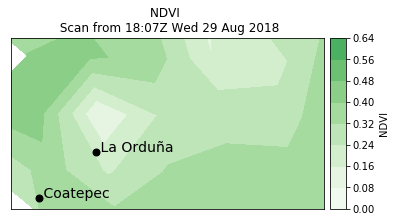

In [157]:
#Grafica NDVI:
#Tomar solo los valores positivos y recortar a las latitudes de la imagen, convertir de datos a lats 

lons_subset=lons[0:-1,0:-1]
lats_subset=lats[0:-1,0:-1]
data_subset=NDVI[0:-1,0:-1]
mask = data_subset <0.0
data_subset[mask] = np.nan

# Plot with zoomed domain for brightness temperature
#bmap = Basemap(projection='cyl',llcrnrlat=19.27,urcrnrlat=19.29,llcrnrlon=-96.58,  urcrnrlon=-96.54,  resolution='l')
#bmap = Basemap(projection='cyl', llcrnrlon=-117.5, llcrnrlat=15, urcrnrlon=-86.8, urcrnrlat=33,  resolution='i')
bmap = Basemap(projection='cyl',llcrnrlat=19.27,urcrnrlat=19.30,llcrnrlon=-96.575,  urcrnrlon=-96.52,  resolution='l')

bmap.contourf(lons_subset,lats_subset,data_subset,cmap=plt.get_cmap('Greens'),vmin=0.0,vmax=1.0)
# Insert the legend
bmap.colorbar(location='right', label='NDVI')
bmap.drawcoastlines()
date_formatted = datetime.strftime(datetime_start,'%H:%MZ %a %d %b %Y')
plt.title("NDVI \n Scan from " +date_formatted)
# Show the plot
plt.rcParams['figure.figsize'] = (6,6)

x, y = bmap(-96.56, 19.28)
plt.plot(x, y, 'ok', markersize=7)
plt.text(x, y, u' La Orduña', fontsize=14)

x, y = bmap(-96.57, 19.2719)
plt.plot(x, y, 'ok', markersize=7)
plt.text(x, y, ' Coatepec', fontsize=14)

title = '/home/olmo/Documents/Hflux_PR/images/Orduna/' + date_formatted + '.png'
plt.show()


## Variación anual del NDVI

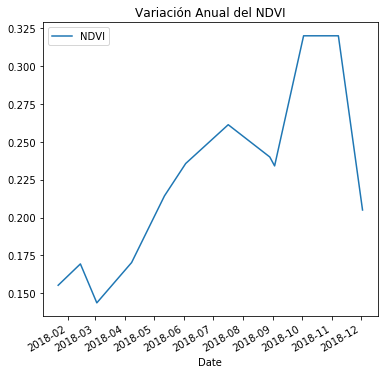

In [176]:
NDVI_dict = {'22 Jan 2018':0.1553,'14 Feb 2018':0.1694,'03 Mar 2018':0.1437,'08 Apr 2018':0.1703,'12 May 2018':0.2143,'03 Jun 2018':0.2357,'17 Jul 2018':0.2613,'29 Aug 2018':0.24, '03 Sep 2018': 0.2341,'03 Oct 2018':0.32,'08 Nov 2018':0.32,'03 Dec 2018':0.205}                                                                                                                                                                                   
df = pd.DataFrame(NDVI_dict.items(),columns=['Date','NDVI'] )
df['Date'] = pd.to_datetime(df['Date'], format='%d %b %Y', utc=True)
df=df.set_index('Date')
df = df.sort_index()
df.plot()
plt.title(u'Variación Anual del NDVI')
plt.show()

### Esta gráfica fue construída a partir de tomar 1 día de cada mes y calcular el NDVI a las 12:07 (18:07 UTC). 

### Durante todo el año los valores están por debajo del reportado para vegetación (0.3) . Para verificar si se trata de la resolución se amplío la imagen a distintos tamaños y se encontró que solo en escala regional o mayor se obtienen valores entre 0.3 y 0.7 , puede entonces haber un factor de escala.  Para explorar si la hora del día y por tanto el ángulo de radiación sobre el área afectan en el cálculo (o en el factor de escala) se calculó el NDVI para el día 29 de agosto, tomando datos en el mínuto 32 desde las 10:32 (16:32 UTC) hasta las 19:30(23:30 UTC)

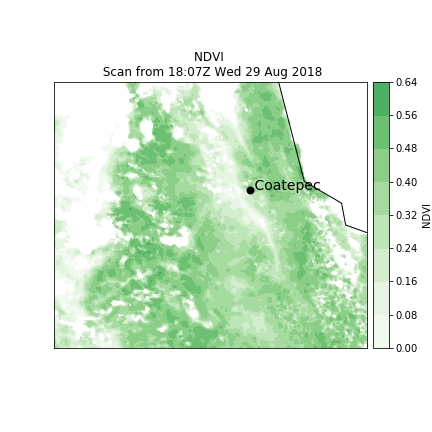

In [199]:
#NDVI en una escala regional: 
Image(filename='/home/olmo/Documents/Hflux_PR/images/Orduna/29AUG2018/AA18:07Z Wed 29 Aug 2018.png')

### En esta gráfica de escala regional es posible observar que los valores del NDVI distinguen bien entre vegetación y nubes,  lo cual sugiere que para calcular el índice la capa de nubes puede afectar, esto puede ser explorado calculando el NDVI a distintas horas del día para la región de Coatepec.

# NDVI a distintas horas del día el 29 de agosto de 2018:

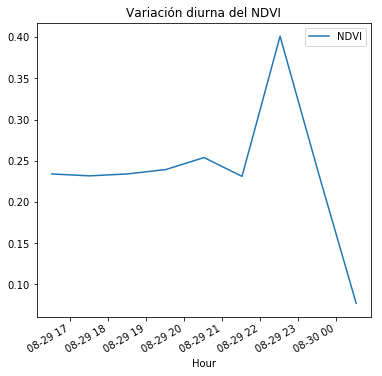

In [178]:
NDVI_dict = {'16:32Z 29 Aug 2018':0.234,'17:32Z 29 Aug 2018':0.2317,'19:32Z 29 Aug 2018':0.2394, '18:32Z 29 Aug 2018':0.2341,'20:32Z 29 Aug 2018':0.2539,'21:32Z 29 Aug 2018':0.2311,'22:32Z 29 Aug 2018':0.4010,'23:32Z 29 Aug 2018':0.2367,'00:32Z 30 Aug 2018':0.1100,'00:32Z 30 Aug 2018':0.0772}                                                                                                                                                                                   
df = pd.DataFrame(NDVI_dict.items(),columns=['Hour','NDVI'] )
df['Hour'] = pd.to_datetime(df['Hour'], format='%H:%MZ %d %b %Y', utc=True)
df=df.set_index('Hour')
df = df.sort_index()
df.plot()
plt.title(u'Variación diurna del NDVI')
plt.show()

### La gráfica muestra un pico a las 22:32 UTC (16:32 hora local), este pico correspondo a un valor de NDVI de 0.4, dentro del teórico para vegetación, por tanto usaremos esta hora para probar otros meses durante el año y ver si en realidad es esta una hora óptima o si depende de otro fáctor.

# NDVI a las 16:32 (22:32 UTC) durante el año

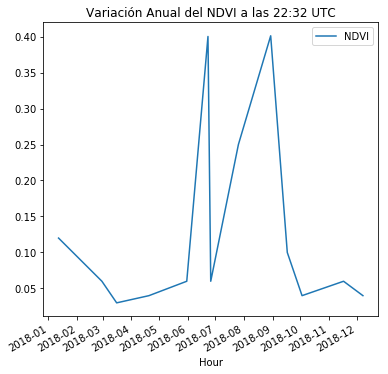

In [179]:
NDVI_dict = {'22:32Z 29 Aug 2018':0.40105,'22:32Z 15 Mar 2018':0.03,'22:32Z 22 Jun 2018':0.4001,'22:32Z 16 Sep 2018':0.1000,'22:32Z 07 Dec 2018':0.04,'22:32Z 25 Jun 2018':0.06,'22:32Z 25 Jul 2018':0.25,'22:32Z 11 Jan 2018':0.12,'22:32Z 27 Feb 2018':0.06,'22:32Z 19 Apr 2018':0.04,'22:32Z 30 May 2018':0.06,'22:32Z 02 Oct 2018':0.0400,'22:32Z 16 Nov 2018':0.06}                                                                                                                                                      
df = pd.DataFrame(NDVI_dict.items(),columns=['Hour','NDVI'] )
df['Hour'] = pd.to_datetime(df['Hour'], format='%H:%MZ %d %b %Y', utc=True)
df=df.set_index('Hour')
df = df.sort_index()
df.plot()
plt.title(u'Variación Anual del NDVI a las 22:32 UTC')
plt.show()

### La gráfica muestra que esta hora no es óptima a lo largo del año para estimar el NDVI,  sin embargo hay algunos meses en que podría serlo, esto sugiere que quiza no haya un factor de escala, sino que las nubes u otro factor limitan la estimación del índice, por tanto habría que tomar distintas imágenes y de alguna forma fusionarlas para quitar estas limitaciones. Lo anterior coincide con lo reportado en el manual del futuro producto de NDVI de la serie GOES, en que se menciona que la resolución espacial será de 2km y se reportará una vez por hora. Sin embargo no hacen mención explícita de la forma en que fusionan los archivos.

# ¿Cómo hacer correctamente la fusión de archivos?

## Bibliografía 

Reporte técnico sobre el futuro producto NDVI de la serie GOESR: https://www.goes-r.gov/products/ATBDs/option2/Land_NDVI_v2.0_no_color.pdf

Nobel, Park S. (1991) Physicochemical and environmental plant physiology, Academic Press

articulos (pégalos)